## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images


In [2]:
import time

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import math
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from camCalibrate import camCalibrate
from thresholder import *
from thresholding_main import thresholding
from helper import *
from Line import *



### 1. Camera Calibration and Distortion Correction

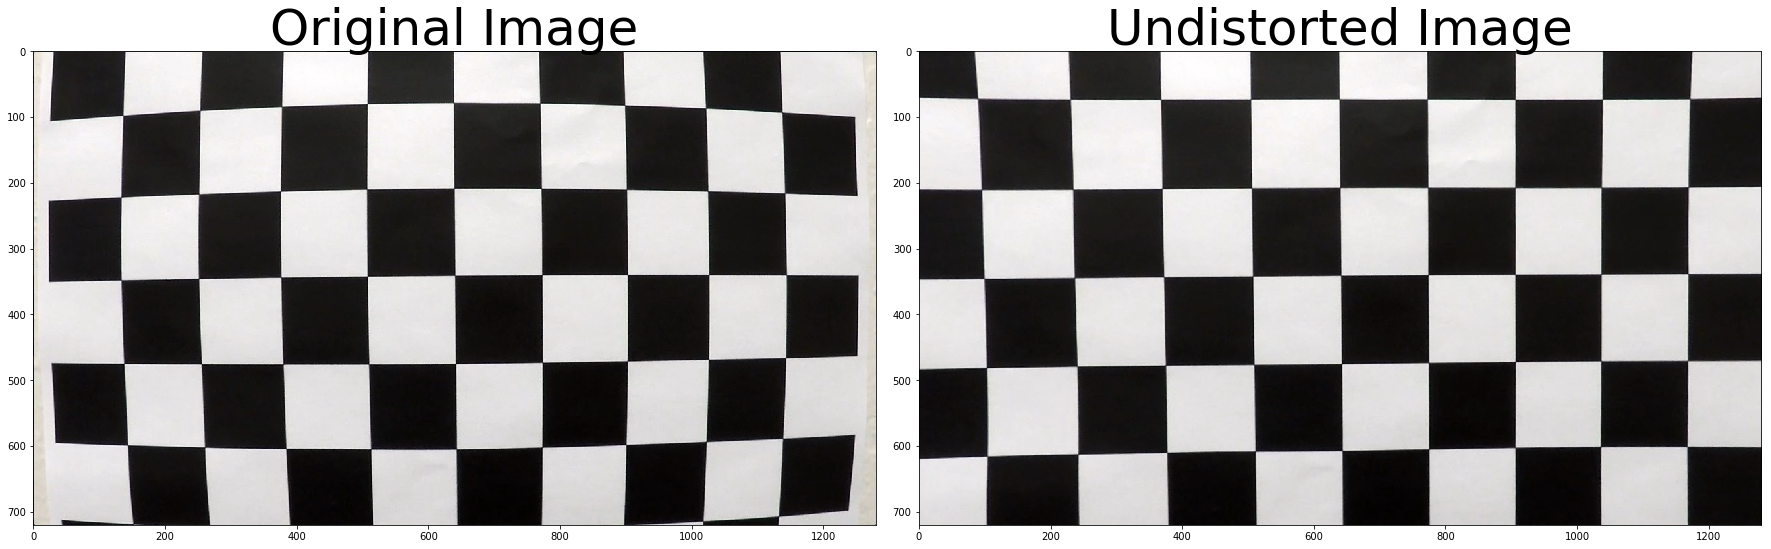

In [3]:
# camCalibrate() give 
objpoints,imgpoints = camCalibrate()

# camera calibrate and undistort image by cal_undistort()
test_img = plt.imread('./camera_cal/calibration1.jpg')
undist_test = cal_undistort(test_img, objpoints, imgpoints)

# see result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_test)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.savefig("output_images/chessBoardDistor.png")

## 2. Color and Gradient Thresholding

Here, we get a binary image by using gradient and color space threshold.

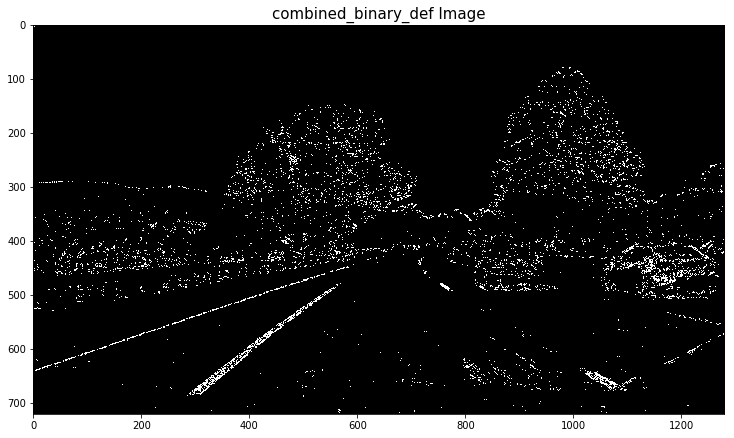

In [4]:
image = mpimg.imread('./test_images/test1.jpg')

# combining HLS image S channel x gradient and S channel
combined_binary_def = color_thresh_def(image, s_thresh=(170, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1) = plt.subplots(1, 1, figsize=(18, 6))
f.tight_layout()
ax1.imshow(combined_binary_def, cmap='gray')
ax1.set_title('combined_binary_def Image', fontsize=15)
plt.subplots_adjust(left=0., right=0.8, top=0.9, bottom=0.)
#plt.show()

#plt.savefig("output_images/combined_binary.png")

## 3. Perspective Transform 


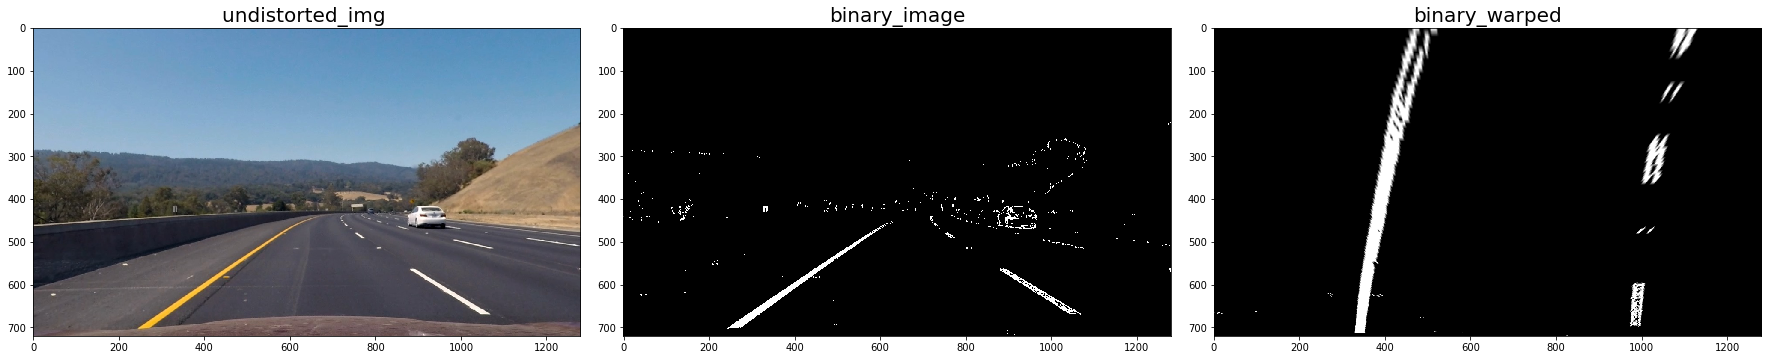

In [7]:
# read test image
frame = mpimg.imread('./test_images/test3.jpg')

# undistort image
undistorted_img = cal_undistort(frame, objpoints, imgpoints)
# apply color and gradient thresholding
binary_image = color_thresh(undistorted_img, s_thresh=(170, 255), sx_thresh=(20, 100))
# warp the image to "bird-eye view"
binary_warped,M,Minv = warp(binary_image)

# See result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('undistorted_img ', fontsize=20)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('binary_image', fontsize=20)
ax3.imshow(binary_warped, cmap='gray')
ax3.set_title('binary_warped', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.savefig("output_images/perspectivetTransformation.png")

## 4. Window and Prior Search

 After getting the lane lines, we need to find the line pixels and a polynomial which fit with these points. There are two different ways for finding pixels, sliding windows approach and prior search.

### 4.1. Window Search

First way is window searching. Look over all image and find the pixels. İt's slower than prior search but if you don't have any previous lane lines, you have to use window searching.

In [8]:
def sliding_window(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin  
        win_xright_low = rightx_current-margin  
        win_xright_high = rightx_current+margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) &
                          (nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If found > minpix pixels, recenter next window 
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
        

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #  we have the pixel positions and we can find the polynomial.
    left_fitx, right_fitx,ploty = fit_polynomial(binary_warped.shape,leftx,lefty,rightx,righty)
    
        # Color in left and right line pixels
    out_img[lefty,leftx] = [255, 0, 0]
    out_img[righty,rightx] = [0, 0, 255]
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='green')
    
    return out_img*255
    

### 4.2. Prior Search

If we have a previous lane lines than we can use the search_around_poly(). The differences between windows-searching and search_around_poly is we don't have to search around all image. We know previous lane line and it is enough to just looking around these lines.

In [9]:
def search_around_poly(binary_warped):
    """
    First run sliding window, to call this method the Line object should have polynom,
    
    :return: left, right lines polynom which calculated by fit_polynomial function
    """
    # HYPERPARAMETER
    # The margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # get previous polynomial which represent the lane lines.
    left_fit = left_line.poly
    right_fit = right_line.poly
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    # here we have filter and nonzero-pixel values
    # we filter these nonzero-values (only take the pixel which inside the filter region)
    # so these leftx-y, rightx-y are the cord. of left and right line pixels.
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    # fit_polynomial returns the x points position for visualization.
    left_fitx, right_fitx,ploty = fit_polynomial(binary_warped.shape,leftx,lefty,rightx,righty)
    #left_fit, right_fit = fit_polynomial()
    
        ## Visualization ##
        
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='green')
    ## End visualization steps ##
    return result*255

In [10]:
def fit_polynomial(img_shape,leftx,lefty,rightx,righty):
      
    # by using point position fit a polytnomial.
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # set Line object polynomial values to new polynomial.
    left_line.poly = left_fit    
    right_line.poly = right_fit
    
    
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    # these are the x-y point comes from polynomial
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # set Line object x-y values.
    left_line.allx = left_fitx
    #left_line.ally = lefty
    right_line.allx = right_fitx
    #right_line.ally = righty
    
    return left_fitx,right_fitx,ploty

### Example Results

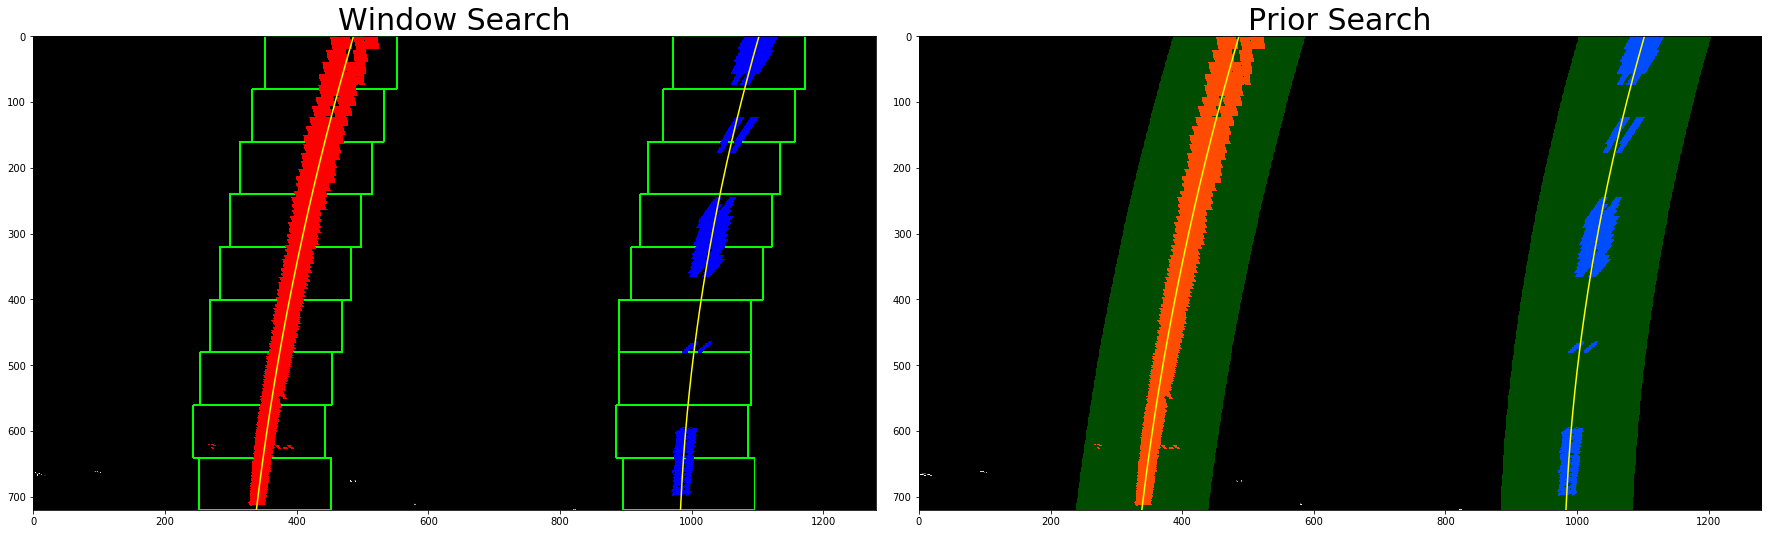

In [11]:
left_line = Line(bins=10)
right_line = Line(bins=10)

window_search = sliding_window(binary_warped)
prior_search = search_around_poly(binary_warped)


# See result
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(window_search)
ax1.set_title('Window Search', fontsize=30)
ax1.plot(left_line.allx, ploty, color='yellow')
ax1.plot(right_line.allx, ploty, color='yellow')

ax2.imshow(prior_search)
ax2.set_title('Prior Search', fontsize=30)
ax2.plot(left_line.allx, ploty, color='yellow')
ax2.plot(right_line.allx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



## 5. Curvature

Now, we have the polynomial which represents the lane lines. By using the formula, we can find the left-right lane line curvature.

[//]: # (Image References)
[image5]: ./output_images/radiusFormula.png "Curvature"
![alt text][image5]

In [12]:
def measure_curvature_real(ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    
    :return: left_fit_cr: left lane curvature
    :return: ight_fit_cr: rright lane curvature
    '''
    # get polynom
    left_fit = left_line.poly
    right_fit = right_line.poly
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # find curvature by using the formula
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # set the Line.curvature values to the calculated value.
    left_line.curvature = left_curverad
    right_line.curvature = right_curverad
    
    return left_curverad, right_curverad


## 6. Draw Lane

In [21]:
def draw_lane(undistorted, binary_warped):
    
    # Create an image to draw the lines on
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))    
    
    # get the values
    l_poly_list = left_line.poly_list
    r_poly_list = right_line.poly_list
    l_radius_list = left_line.curv_list
    r_radius_list = right_line.curv_list
    
    # take avg of lines if more than one
    if len(l_poly_list) > 0 :#np.ndim(weights):
        weights = np.arange(1,len(l_radius_list)+1)/len(l_radius_list)
        print("avg of %d  lines"%(len(l_poly_list)))
        left_fit = np.average(l_poly_list,0,weights[-len(l_poly_list):])
        right_fit = np.average(r_poly_list,0,weights[-len(l_poly_list):])
        left_curverad = np.average(l_radius_list,0,weights[-len(l_poly_list):])
        right_curverad = np.average(r_radius_list,0,weights[-len(l_poly_list):])
    
    else:
        # here if we don't have any previous lane
        # that's means first frame couldn't pass the sanity_check()
        # here, we can pass the frame 
        # or use calculated lane even it couldn't pass the sanity_check()
        # i prefered not to use it.
        return undistorted
        print("Draw the new line")
        left_fit = left_line.poly
        right_fit = right_line.poly
        left_curverad = left_line.curvature
        right_curverad = right_line.curvature
    
    
    
    # get the pixel point positions.
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # find the center and offset
    midpoint = np.int(undistorted.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    offset = (midpoint - middle_of_lane) * xm_per_pix

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    # here we are giving 2 lane and this fillPoly fill the gap between these 2 line and
    # make a fullfill "rectangle" - dörtgen
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))
    #plt.imshow(color_warped)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    unwarped = cv2.warpPerspective(color_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, unwarped, 0.3, 0)
    radius = np.mean([left_curverad, right_curverad])
    
    left_km_cr = left_curverad/1000
    right_km_cr = right_curverad/1000
    diff_cr = np.absolute(left_km_cr-right_km_cr)

    # Add radius and offset calculations to top of video
    cv2.putText(result,"L. Lane Radius: " + "{:0.2f}".format(left_km_cr) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"R. Lane Radius: " + "{:0.2f}".format(right_km_cr) + 'km', org=(50,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"Diff of Lines : " + "{:0.2f}".format(diff_cr) + 'km', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position: " + "{:0.2f}".format(offset) + 'm', org=(50,200), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)

    return result


In [22]:
def sanity_check():
    
    # default return
    result = True
    
    # get polynoms and curv. values
    left_fit = left_line.poly
    right_fit = right_line.poly
    left_curverad = left_line.curvature
    right_curverad = right_line.curvature
    l_radius_list = left_line.curv_list
    r_radius_list = right_line.curv_list
    
    # meters to km
    left_km_cr = left_curverad/1000
    right_km_cr = right_curverad/1000
    
    # new left-right differences threshold
    thresh1=5
    # differences between new lanes and average.
    thresh2=15
    
    ### 1 ---------------------Check----------------------------###
    ## Checking that they have similar curvature
    diff_cr = np.absolute(right_km_cr-left_km_cr)
    
    if diff_cr>thresh1:
        print("FAİLED - no similir left-right  left: %f  right: %f  diff:  %f"%(left_km_cr,right_km_cr,diff_cr))
        return False
    
    ### 2 ---------------------Check----------------------------###
    ## Checking the new curvature is similar to the average_curv.
    if len(l_radius_list)>1:

        weights = np.arange(1,len(l_radius_list)+1)/len(l_radius_list)
        left_avg =np.average(l_radius_list,0,weights[-len(l_radius_list):])/1000
        right_avg =np.average(r_radius_list,0,weights[-len(l_radius_list):])/1000

        left_diff = np.absolute(left_km_cr-left_avg)
        right_diff = np.absolute(right_km_cr-right_avg)
        
        # also check the last and new curv differences.
        last_diff_l = np.absolute((l_radius_list[-1]/1000)-left_km_cr)
        last_diff_r = np.absolute((r_radius_list[-1]/1000)-right_km_cr)
        
        if left_diff>thresh2 or right_diff>thresh2 or last_diff_l>thresh2 or last_diff_r>thresh2:
            print("FAİLED - not similar with average_cur")
            print("left_avg: %f  left_new: %f"%(left_avg,left_km_cr))
            print("right_avg: %f  right_new: %f"%(right_avg,right_km_cr))
            print("left_last: %f  left_new: %f"%((l_radius_list[-1]/1000),left_km_cr))
            print("right_last: %f  right_new: %f"%((r_radius_list[-1]/1000),right_km_cr))
            return False
    
    
    ###3 ---------------------Check---------------------------###
    ## Checking that they are separated by approximately the right distance horizontally
    
    # src : (580, 460), (205, 720), (1110, 720), (703, 460)
    # min distance : 703-580  =  123
    # max distance : 1110-205 =  905

    ploty = np.linspace(460, 720-1, 260)
    left_points = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_points = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    diff_list = (right_points-left_points)
    check = ((diff_list>905) | (diff_list<123))
    outlier = diff_list[check]
    if len(outlier)>0:
        print("FAİLED - not parallel / num of outliar: %d"%(len(outlier)))
        return False
    
    
    return result

#### Testing for sanity_check

In [23]:

left_fit = left_line.poly
right_fit = right_line.poly

ploty = np.linspace(460, 720-1, 260)
left_points = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_points = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

diff_list = (right_points-left_points)
check = ((diff_list<905) & (diff_list>123))
outliar = diff_list[check]

print(len(outliar))

260


In [24]:
def resetList(passThreshold):
    """
    Reset all list, polynoms and pixels points
    Set passedNumber to threshold for start againg window_seach
    """
    # radiues list
    left_line.poly_list = deque(maxlen=left_line.bins)
    right_line.curv_list = deque(maxlen=right_line.bins)
    # polynomial
    left_line.poly = None
    right_line.poly = None
    # points
    left_line.allx = None
    right_line.ally = None
    
    # number of frame we passed
    # set to threshold for start again with sliding window search.
    left_line.passNumber = passThreshold
    

## Build Pipline

In [25]:
def pipline_video(frame):

    passThreshold = 5
    
    ## undistort image
    undistorted_img = cal_undistort(frame, objpoints, imgpoints)
    
    ## warp image
    warped_img,M,Minv = warp(undistorted_img)
    
    ## thresholding
    binary_warped = color_thresh_def(warped_img, s_thresh=(170, 255), sx_thresh=(20, 100))
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    
    ## windows and prior search
    print("Start--> List Length : ",len(left_line.poly_list))
    if len(left_line.poly_list)>0 and (left_line.passNumber%passThreshold)!=0:
        search_around_poly(binary_warped)
        print("Prior_search") 
    else:
        #resetList()
        sliding_window(binary_warped)
        print("Window_searching  passed_frame_num : ",left_line.passNumber)
        left_line.passNumber = 1
    
    
    ## Curvature 
    left_curverad, right_curverad = measure_curvature_real(ploty)
    
    
    ## Sanity Check
    if  sanity_check():# or len(left_line.poly_list)<=10:
        print("Passed sanity_check")
        # mean of lines and curves
        left_line.poly_list.append(left_line.poly)
        left_line.curv_list.append(left_line.curvature)
        right_line.poly_list.append(right_line.poly)
        right_line.curv_list.append(right_line.curvature)
        left_line.passNumber = 1
    else:
        left_line.passNumber +=1
        if len(left_line.poly_list)<=0:
            resetList(passThreshold)
            left_line.passNumber = 5
       
    ## Drawing
    result = draw_lane(undistorted_img, binary_warped)

    
    print("----------------")
    print("End--> List Length : %d"%(len(left_line.curv_list)))
    print("left %.3f  right %.3f "%(left_line.curvature/1000,right_line.curvature/1000))
    print("----------------")

    
    
    return result

## Test with Video

In [26]:
# size of list
bins = 20

# left and right lane objects
left_line = Line(bins=bins)
right_line = Line(bins=bins)
left_line.passNumber = 1

white_output = 'output_videos/project_video-result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# project_video  challenge_video  harder_challenge_video
#clip1 = VideoFileClip("project_video.mp4").subclip(42,45)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipline_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Start--> List Length :  0
Window_searching  passed_frame_num :  1
FAİLED - not parallel / num of outliar: 5
----------------
End--> List Length : 0
left 1.638  right 3.783 
----------------
[MoviePy] >>>> Building video output_videos/harder_challenge_video-result.mp4
[MoviePy] Writing video output_videos/harder_challenge_video-result.mp4



  0%|          | 1/251 [00:01<05:16,  1.27s/it]

Start--> List Length :  0
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 5
----------------
End--> List Length : 0
left 1.638  right 3.783 
----------------



  1%|          | 2/251 [00:02<05:17,  1.28s/it]

Start--> List Length :  0
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 58
----------------
End--> List Length : 0
left 1.701  right 6.560 
----------------



  1%|          | 3/251 [00:03<05:17,  1.28s/it]

Start--> List Length :  0
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 1  lines
----------------
End--> List Length : 1
left 1.769  right 2.791 
----------------



  2%|▏         | 4/251 [00:05<05:16,  1.28s/it]

Start--> List Length :  1
Prior_search
Passed sanity_check
avg of 2  lines
----------------
End--> List Length : 2
left 1.802  right 5.430 
----------------



  2%|▏         | 5/251 [00:06<05:15,  1.28s/it]

Start--> List Length :  2
Prior_search
Passed sanity_check
avg of 3  lines
----------------
End--> List Length : 3
left 1.865  right 3.828 
----------------



  2%|▏         | 6/251 [00:07<05:15,  1.29s/it]

Start--> List Length :  3
Prior_search
Passed sanity_check
avg of 4  lines
----------------
End--> List Length : 4
left 1.898  right 0.969 
----------------



  3%|▎         | 7/251 [00:09<05:13,  1.29s/it]

Start--> List Length :  4
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.836  right 0.775 
----------------



  3%|▎         | 8/251 [00:10<05:12,  1.29s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.795  right 0.732 
----------------



  4%|▎         | 9/251 [00:11<05:11,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 15
avg of 5  lines
----------------
End--> List Length : 5
left 1.800  right 0.683 
----------------



  4%|▍         | 10/251 [00:12<05:09,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 29
avg of 5  lines
----------------
End--> List Length : 5
left 1.803  right 0.724 
----------------



  4%|▍         | 11/251 [00:14<05:07,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 53
avg of 5  lines
----------------
End--> List Length : 5
left 1.826  right 0.771 
----------------



  5%|▍         | 12/251 [00:15<05:06,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 72
avg of 5  lines
----------------
End--> List Length : 5
left 1.840  right 0.813 
----------------



  5%|▌         | 13/251 [00:16<05:05,  1.28s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 164
avg of 5  lines
----------------
End--> List Length : 5
left 1.849  right 4.578 
----------------



  6%|▌         | 14/251 [00:17<05:04,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.865294  right: 11.905783  diff:  10.040488
avg of 5  lines
----------------
End--> List Length : 5
left 1.865  right 11.906 
----------------



  6%|▌         | 15/251 [00:19<05:03,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 139
avg of 5  lines
----------------
End--> List Length : 5
left 1.874  right 5.456 
----------------



  6%|▋         | 16/251 [00:20<05:02,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 141
avg of 5  lines
----------------
End--> List Length : 5
left 1.894  right 1.779 
----------------



  7%|▋         | 17/251 [00:21<05:01,  1.29s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 1.900  right 1.404 
----------------



  7%|▋         | 18/251 [00:23<05:00,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.959921  right: 9.065753  diff:  7.105832
avg of 5  lines
----------------
End--> List Length : 5
left 1.960  right 9.066 
----------------



  8%|▊         | 19/251 [00:24<04:58,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 88
avg of 5  lines
----------------
End--> List Length : 5
left 2.181  right 2.621 
----------------



  8%|▊         | 20/251 [00:25<04:57,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 74
avg of 5  lines
----------------
End--> List Length : 5
left 2.222  right 2.999 
----------------



  8%|▊         | 21/251 [00:27<04:55,  1.29s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 72
avg of 5  lines
----------------
End--> List Length : 5
left 2.111  right 1.461 
----------------



  9%|▉         | 22/251 [00:28<04:54,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 85
avg of 5  lines
----------------
End--> List Length : 5
left 2.475  right 0.926 
----------------



  9%|▉         | 23/251 [00:29<04:53,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 95
avg of 5  lines
----------------
End--> List Length : 5
left 2.541  right 0.937 
----------------



 10%|▉         | 24/251 [00:30<04:52,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 105
avg of 5  lines
----------------
End--> List Length : 5
left 2.582  right 1.432 
----------------



 10%|▉         | 25/251 [00:32<04:50,  1.29s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 2.335347  right: 7.639022  diff:  5.303675
avg of 5  lines
----------------
End--> List Length : 5
left 2.335  right 7.639 
----------------



 10%|█         | 26/251 [00:33<04:48,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 164
avg of 5  lines
----------------
End--> List Length : 5
left 2.918  right 1.011 
----------------



 11%|█         | 27/251 [00:34<04:47,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 155
avg of 5  lines
----------------
End--> List Length : 5
left 2.970  right 1.129 
----------------



 11%|█         | 28/251 [00:36<04:46,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 156
avg of 5  lines
----------------
End--> List Length : 5
left 2.976  right 1.587 
----------------



 12%|█▏        | 29/251 [00:37<04:44,  1.28s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 2.651485  right: 10.135599  diff:  7.484114
avg of 5  lines
----------------
End--> List Length : 5
left 2.651  right 10.136 
----------------



 12%|█▏        | 30/251 [00:38<04:43,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 208
avg of 5  lines
----------------
End--> List Length : 5
left 3.017  right 0.915 
----------------



 12%|█▏        | 31/251 [00:39<04:42,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 189
avg of 5  lines
----------------
End--> List Length : 5
left 3.016  right 1.552 
----------------



 13%|█▎        | 32/251 [00:41<04:41,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 190
avg of 5  lines
----------------
End--> List Length : 5
left 3.044  right 1.827 
----------------



 13%|█▎        | 33/251 [00:42<04:40,  1.29s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 2.797  right 1.484 
----------------



 14%|█▎        | 34/251 [00:43<04:39,  1.29s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 3.222  right 3.248 
----------------



 14%|█▍        | 35/251 [00:44<04:37,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 3.649  right 1.404 
----------------



 14%|█▍        | 36/251 [00:46<04:36,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 4.032  right 2.448 
----------------



 15%|█▍        | 37/251 [00:47<04:34,  1.28s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 3.744  right 1.375 
----------------



 15%|█▌        | 38/251 [00:48<04:34,  1.29s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 5.075  right 1.609 
----------------



 16%|█▌        | 39/251 [00:50<04:32,  1.29s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 5.697  right 1.960 
----------------



 16%|█▌        | 40/251 [00:51<04:30,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 6.544093  right: 12.058097  diff:  5.514004
avg of 5  lines
----------------
End--> List Length : 5
left 6.544  right 12.058 
----------------



 16%|█▋        | 41/251 [00:52<04:29,  1.28s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 7.161  right 2.208 
----------------



 17%|█▋        | 42/251 [00:53<04:27,  1.28s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.366539  right: 1.990246  diff:  5.376293
avg of 5  lines
----------------
End--> List Length : 5
left 7.367  right 1.990 
----------------



 17%|█▋        | 43/251 [00:55<04:48,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.646857  right: 1.610432  diff:  6.036425
avg of 5  lines
----------------
End--> List Length : 5
left 7.647  right 1.610 
----------------



 18%|█▊        | 44/251 [00:57<04:47,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 8.337024  right: 2.991982  diff:  5.345043
avg of 5  lines
----------------
End--> List Length : 5
left 8.337  right 2.992 
----------------



 18%|█▊        | 45/251 [00:58<04:44,  1.38s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 8.826  right 4.046 
----------------



 18%|█▊        | 46/251 [00:59<04:44,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.671154  right: 1.191741  diff:  8.479413
avg of 5  lines
----------------
End--> List Length : 5
left 9.671  right 1.192 
----------------



 19%|█▊        | 47/251 [01:01<04:41,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.944404  right: 0.888119  diff:  9.056285
avg of 5  lines
----------------
End--> List Length : 5
left 9.944  right 0.888 
----------------



 19%|█▉        | 48/251 [01:02<04:43,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.788617  right: 0.901772  diff:  8.886844
avg of 5  lines
----------------
End--> List Length : 5
left 9.789  right 0.902 
----------------



 20%|█▉        | 49/251 [01:03<04:40,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.394364  right: 1.095247  diff:  9.299116
avg of 5  lines
----------------
End--> List Length : 5
left 10.394  right 1.095 
----------------



 20%|█▉        | 50/251 [01:05<04:41,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 4.319  right 5.906 
----------------



 20%|██        | 51/251 [01:06<04:41,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.072045  right: 1.118722  diff:  8.953324
avg of 5  lines
----------------
End--> List Length : 5
left 10.072  right 1.119 
----------------



 21%|██        | 52/251 [01:08<04:39,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.360783  right: 1.005558  diff:  9.355225
avg of 5  lines
----------------
End--> List Length : 5
left 10.361  right 1.006 
----------------



 21%|██        | 53/251 [01:09<04:39,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.226440  right: 1.147250  diff:  9.079191
avg of 5  lines
----------------
End--> List Length : 5
left 10.226  right 1.147 
----------------



 22%|██▏       | 54/251 [01:10<04:35,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.580168  right: 1.374568  diff:  9.205600
avg of 5  lines
----------------
End--> List Length : 5
left 10.580  right 1.375 
----------------



 22%|██▏       | 55/251 [01:12<04:36,  1.41s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 8.316210  right: 2.881189  diff:  5.435020
avg of 5  lines
----------------
End--> List Length : 5
left 8.316  right 2.881 
----------------



 22%|██▏       | 56/251 [01:13<04:33,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 11.539691  right: 1.375009  diff:  10.164682
avg of 5  lines
----------------
End--> List Length : 5
left 11.540  right 1.375 
----------------



 23%|██▎       | 57/251 [01:15<04:32,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 11.606951  right: 1.135854  diff:  10.471097
avg of 5  lines
----------------
End--> List Length : 5
left 11.607  right 1.136 
----------------



 23%|██▎       | 58/251 [01:16<04:32,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 11.674317  right: 1.110907  diff:  10.563410
avg of 5  lines
----------------
End--> List Length : 5
left 11.674  right 1.111 
----------------



 24%|██▎       | 59/251 [01:18<04:29,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 6.846538  right: 1.249532  diff:  5.597005
avg of 5  lines
----------------
End--> List Length : 5
left 6.847  right 1.250 
----------------



 24%|██▍       | 60/251 [01:19<04:28,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 23.290838  right: 1.280531  diff:  22.010307
avg of 5  lines
----------------
End--> List Length : 5
left 23.291  right 1.281 
----------------



 24%|██▍       | 61/251 [01:20<04:26,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 27.222055  right: 1.583172  diff:  25.638883
avg of 5  lines
----------------
End--> List Length : 5
left 27.222  right 1.583 
----------------



 25%|██▍       | 62/251 [01:22<04:26,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 27.011508  right: 1.935310  diff:  25.076198
avg of 5  lines
----------------
End--> List Length : 5
left 27.012  right 1.935 
----------------



 25%|██▌       | 63/251 [01:23<04:22,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 18.625238  right: 1.903522  diff:  16.721716
avg of 5  lines
----------------
End--> List Length : 5
left 18.625  right 1.904 
----------------



 25%|██▌       | 64/251 [01:25<04:23,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 22.273093  right: 2.611343  diff:  19.661750
avg of 5  lines
----------------
End--> List Length : 5
left 22.273  right 2.611 
----------------



 26%|██▌       | 65/251 [01:26<04:19,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 20.961318  right: 3.061956  diff:  17.899363
avg of 5  lines
----------------
End--> List Length : 5
left 20.961  right 3.062 
----------------



 26%|██▋       | 66/251 [01:27<04:20,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 19.177080  right: 2.840357  diff:  16.336723
avg of 5  lines
----------------
End--> List Length : 5
left 19.177  right 2.840 
----------------



 27%|██▋       | 67/251 [01:29<04:16,  1.39s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 24.521582  right: 2.302859  diff:  22.218722
avg of 5  lines
----------------
End--> List Length : 5
left 24.522  right 2.303 
----------------



 27%|██▋       | 68/251 [01:30<04:16,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 30.358554  right: 24.586180  diff:  5.772374
avg of 5  lines
----------------
End--> List Length : 5
left 30.359  right 24.586 
----------------



 27%|██▋       | 69/251 [01:32<04:15,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 28.214124  right: 2.081261  diff:  26.132863
avg of 5  lines
----------------
End--> List Length : 5
left 28.214  right 2.081 
----------------



 28%|██▊       | 70/251 [01:33<04:15,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 26.716197  right: 1.153389  diff:  25.562807
avg of 5  lines
----------------
End--> List Length : 5
left 26.716  right 1.153 
----------------



 28%|██▊       | 71/251 [01:34<04:12,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 32.303948  right: 2.518287  diff:  29.785662
avg of 5  lines
----------------
End--> List Length : 5
left 32.304  right 2.518 
----------------



 29%|██▊       | 72/251 [01:36<04:14,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 26.610346  right: 1.180713  diff:  25.429633
avg of 5  lines
----------------
End--> List Length : 5
left 26.610  right 1.181 
----------------



 29%|██▉       | 73/251 [01:37<04:10,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 22.474812  right: 0.881577  diff:  21.593234
avg of 5  lines
----------------
End--> List Length : 5
left 22.475  right 0.882 
----------------



 29%|██▉       | 74/251 [01:39<04:10,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 16.590187  right: 0.853350  diff:  15.736837
avg of 5  lines
----------------
End--> List Length : 5
left 16.590  right 0.853 
----------------



 30%|██▉       | 75/251 [01:40<04:06,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 10.851963  right: 1.279827  diff:  9.572136
avg of 5  lines
----------------
End--> List Length : 5
left 10.852  right 1.280 
----------------



 30%|███       | 76/251 [01:41<04:06,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 36.331647  right: 0.955929  diff:  35.375718
avg of 5  lines
----------------
End--> List Length : 5
left 36.332  right 0.956 
----------------



 31%|███       | 77/251 [01:43<04:03,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 57.637959  right: 0.861149  diff:  56.776810
avg of 5  lines
----------------
End--> List Length : 5
left 57.638  right 0.861 
----------------



 31%|███       | 78/251 [01:44<04:03,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 63.865259  right: 0.825947  diff:  63.039312
avg of 5  lines
----------------
End--> List Length : 5
left 63.865  right 0.826 
----------------



 31%|███▏      | 79/251 [01:46<04:00,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 3.342  right 1.693 
----------------



 32%|███▏      | 80/251 [01:47<04:00,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 13.433693  right: 0.928092  diff:  12.505601
avg of 5  lines
----------------
End--> List Length : 5
left 13.434  right 0.928 
----------------



 32%|███▏      | 81/251 [01:48<03:56,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 24.807223  right: 0.943080  diff:  23.864143
avg of 5  lines
----------------
End--> List Length : 5
left 24.807  right 0.943 
----------------



 33%|███▎      | 82/251 [01:50<03:56,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 34.940595  right: 0.975412  diff:  33.965183
avg of 5  lines
----------------
End--> List Length : 5
left 34.941  right 0.975 
----------------



 33%|███▎      | 83/251 [01:51<03:54,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 7.113  right 3.264 
----------------



 33%|███▎      | 84/251 [01:53<03:55,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 1.018  right 3.183 
----------------



 34%|███▍      | 85/251 [01:54<03:51,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 0.764  right 1.252 
----------------



 34%|███▍      | 86/251 [01:55<03:51,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 203
avg of 5  lines
----------------
End--> List Length : 5
left 1.014  right 0.966 
----------------



 35%|███▍      | 87/251 [01:57<03:48,  1.39s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 18.383701  right: 1.814622  diff:  16.569079
avg of 5  lines
----------------
End--> List Length : 5
left 18.384  right 1.815 
----------------



 35%|███▌      | 88/251 [01:58<03:48,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 20.818208  right: 1.156479  diff:  19.661729
avg of 5  lines
----------------
End--> List Length : 5
left 20.818  right 1.156 
----------------



 35%|███▌      | 89/251 [02:00<03:45,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 16.452854  right: 1.651534  diff:  14.801320
avg of 5  lines
----------------
End--> List Length : 5
left 16.453  right 1.652 
----------------



 36%|███▌      | 90/251 [02:01<03:44,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 12.934788  right: 2.030888  diff:  10.903900
avg of 5  lines
----------------
End--> List Length : 5
left 12.935  right 2.031 
----------------



 36%|███▋      | 91/251 [02:02<03:44,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 7.244787  right: 2.094219  diff:  5.150569
avg of 5  lines
----------------
End--> List Length : 5
left 7.245  right 2.094 
----------------



 37%|███▋      | 92/251 [02:04<03:40,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 6.793520  right: 1.768786  diff:  5.024734
avg of 5  lines
----------------
End--> List Length : 5
left 6.794  right 1.769 
----------------



 37%|███▋      | 93/251 [02:05<03:40,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 20.293762  right: 2.009823  diff:  18.283939
avg of 5  lines
----------------
End--> List Length : 5
left 20.294  right 2.010 
----------------



 37%|███▋      | 94/251 [02:07<03:39,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 120
avg of 5  lines
----------------
End--> List Length : 5
left 2.199  right 2.067 
----------------



 38%|███▊      | 95/251 [02:08<03:39,  1.41s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 4.569932  right: 16.905475  diff:  12.335543
avg of 5  lines
----------------
End--> List Length : 5
left 4.570  right 16.905 
----------------



 38%|███▊      | 96/251 [02:09<03:36,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 163
avg of 5  lines
----------------
End--> List Length : 5
left 5.157  right 1.868 
----------------



 39%|███▊      | 97/251 [02:11<03:36,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 166
avg of 5  lines
----------------
End--> List Length : 5
left 0.555  right 4.109 
----------------



 39%|███▉      | 98/251 [02:12<03:33,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 169
avg of 5  lines
----------------
End--> List Length : 5
left 0.473  right 2.271 
----------------



 39%|███▉      | 99/251 [02:14<03:34,  1.41s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 2.204  right 1.088 
----------------



 40%|███▉      | 100/251 [02:15<03:41,  1.47s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 170
avg of 5  lines
----------------
End--> List Length : 5
left 0.556  right 1.155 
----------------



 40%|████      | 101/251 [02:17<03:38,  1.46s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 165
avg of 5  lines
----------------
End--> List Length : 5
left 0.581  right 1.278 
----------------



 41%|████      | 102/251 [02:18<03:33,  1.43s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 164
avg of 5  lines
----------------
End--> List Length : 5
left 0.684  right 1.612 
----------------



 41%|████      | 103/251 [02:19<03:32,  1.44s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 30
avg of 5  lines
----------------
End--> List Length : 5
left 0.666  right 1.936 
----------------



 41%|████▏     | 104/251 [02:21<03:28,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 74
avg of 5  lines
----------------
End--> List Length : 5
left 0.922  right 1.783 
----------------



 42%|████▏     | 105/251 [02:22<03:27,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 96
avg of 5  lines
----------------
End--> List Length : 5
left 1.129  right 1.443 
----------------



 42%|████▏     | 106/251 [02:24<03:23,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 103
avg of 5  lines
----------------
End--> List Length : 5
left 0.978  right 1.706 
----------------



 43%|████▎     | 107/251 [02:25<03:23,  1.41s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 20.613107  right: 1.562610  diff:  19.050497
avg of 5  lines
----------------
End--> List Length : 5
left 20.613  right 1.563 
----------------



 43%|████▎     | 108/251 [02:26<03:20,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 99
avg of 5  lines
----------------
End--> List Length : 5
left 1.109  right 2.430 
----------------



 43%|████▎     | 109/251 [02:28<03:19,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 119
avg of 5  lines
----------------
End--> List Length : 5
left 0.543  right 3.678 
----------------



 44%|████▍     | 110/251 [02:29<03:16,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 128
avg of 5  lines
----------------
End--> List Length : 5
left 0.578  right 5.154 
----------------



 44%|████▍     | 111/251 [02:31<03:15,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 161
avg of 5  lines
----------------
End--> List Length : 5
left 0.521  right 2.618 
----------------



 45%|████▍     | 112/251 [02:32<03:15,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 159
avg of 5  lines
----------------
End--> List Length : 5
left 0.632  right 2.678 
----------------



 45%|████▌     | 113/251 [02:33<03:12,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 158
avg of 5  lines
----------------
End--> List Length : 5
left 0.651  right 4.371 
----------------



 45%|████▌     | 114/251 [02:35<03:12,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 157
avg of 5  lines
----------------
End--> List Length : 5
left 0.534  right 4.651 
----------------



 46%|████▌     | 115/251 [02:36<03:09,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 1.560975  right: 13.267059  diff:  11.706085
avg of 5  lines
----------------
End--> List Length : 5
left 1.561  right 13.267 
----------------



 46%|████▌     | 116/251 [02:38<03:09,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 1.423  right 0.993 
----------------



 47%|████▋     | 117/251 [02:39<03:06,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 1.468  right 1.466 
----------------



 47%|████▋     | 118/251 [02:40<03:07,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 231
avg of 5  lines
----------------
End--> List Length : 5
left 2.527  right 1.596 
----------------



 47%|████▋     | 119/251 [02:42<03:03,  1.39s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.790  right 4.808 
----------------



 48%|████▊     | 120/251 [02:43<03:03,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.819  right 4.886 
----------------



 48%|████▊     | 121/251 [02:45<03:01,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.096204  right: 7.025185  diff:  5.928981
avg of 5  lines
----------------
End--> List Length : 5
left 1.096  right 7.025 
----------------



 49%|████▊     | 122/251 [02:46<03:01,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.316168  right: 11.428165  diff:  10.111997
avg of 5  lines
----------------
End--> List Length : 5
left 1.316  right 11.428 
----------------



 49%|████▉     | 123/251 [02:47<02:58,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.458859  right: 13.832847  diff:  12.373987
avg of 5  lines
----------------
End--> List Length : 5
left 1.459  right 13.833 
----------------



 49%|████▉     | 124/251 [02:49<02:58,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.684298  right: 15.019681  diff:  13.335383
avg of 5  lines
----------------
End--> List Length : 5
left 1.684  right 15.020 
----------------



 50%|████▉     | 125/251 [02:50<02:55,  1.39s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.667  right 1.108 
----------------



 50%|█████     | 126/251 [02:52<02:55,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.256  right 1.097 
----------------



 51%|█████     | 127/251 [02:53<02:52,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.543  right 1.194 
----------------



 51%|█████     | 128/251 [02:54<02:53,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.818  right 1.563 
----------------



 51%|█████▏    | 129/251 [02:56<02:50,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 3.175  right 1.385 
----------------



 52%|█████▏    | 130/251 [02:57<02:49,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 3.330  right 1.501 
----------------



 52%|█████▏    | 131/251 [02:59<02:48,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 4.007  right 1.704 
----------------



 53%|█████▎    | 132/251 [03:00<02:46,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 4.068  right 2.614 
----------------



 53%|█████▎    | 133/251 [03:02<02:47,  1.42s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 4.596  right 2.400 
----------------



 53%|█████▎    | 134/251 [03:03<02:44,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 5.129  right 1.119 
----------------



 54%|█████▍    | 135/251 [03:04<02:43,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 5.401  right 0.883 
----------------



 54%|█████▍    | 136/251 [03:06<02:41,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 5.819748  right: 0.814997  diff:  5.004751
avg of 5  lines
----------------
End--> List Length : 5
left 5.820  right 0.815 
----------------



 55%|█████▍    | 137/251 [03:07<02:41,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 5.794259  right: 0.786950  diff:  5.007309
avg of 5  lines
----------------
End--> List Length : 5
left 5.794  right 0.787 
----------------



 55%|█████▍    | 138/251 [03:09<02:38,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 5.930  right 2.657 
----------------



 55%|█████▌    | 139/251 [03:10<02:37,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 6.463  right 8.735 
----------------



 56%|█████▌    | 140/251 [03:11<02:34,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 6.746379  right: 20.984288  diff:  14.237909
avg of 5  lines
----------------
End--> List Length : 5
left 6.746  right 20.984 
----------------



 56%|█████▌    | 141/251 [03:13<02:34,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 6.935866  right: 22.054950  diff:  15.119084
avg of 5  lines
----------------
End--> List Length : 5
left 6.936  right 22.055 
----------------



 57%|█████▋    | 142/251 [03:14<02:31,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.271910  right: 22.228912  diff:  14.957002
avg of 5  lines
----------------
End--> List Length : 5
left 7.272  right 22.229 
----------------



 57%|█████▋    | 143/251 [03:15<02:30,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.690799  right: 23.296989  diff:  15.606190
avg of 5  lines
----------------
End--> List Length : 5
left 7.691  right 23.297 
----------------



 57%|█████▋    | 144/251 [03:17<02:28,  1.39s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 6.962983  right: 52.751860  diff:  45.788878
avg of 5  lines
----------------
End--> List Length : 5
left 6.963  right 52.752 
----------------



 58%|█████▊    | 145/251 [03:18<02:28,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 8.220422  right: 81.413385  diff:  73.192963
avg of 5  lines
----------------
End--> List Length : 5
left 8.220  right 81.413 
----------------



 58%|█████▊    | 146/251 [03:20<02:25,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 8.012339  right: 78.343520  diff:  70.331181
avg of 5  lines
----------------
End--> List Length : 5
left 8.012  right 78.344 
----------------



 59%|█████▊    | 147/251 [03:21<02:25,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.951473  right: 74.959286  diff:  67.007813
avg of 5  lines
----------------
End--> List Length : 5
left 7.951  right 74.959 
----------------



 59%|█████▉    | 148/251 [03:22<02:22,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 7.330906  right: 55.919930  diff:  48.589024
avg of 5  lines
----------------
End--> List Length : 5
left 7.331  right 55.920 
----------------



 59%|█████▉    | 149/251 [03:24<02:22,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.750401  right: 111.109815  diff:  103.359414
avg of 5  lines
----------------
End--> List Length : 5
left 7.750  right 111.110 
----------------



 60%|█████▉    | 150/251 [03:25<02:19,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.913413  right: 114.793249  diff:  106.879836
avg of 5  lines
----------------
End--> List Length : 5
left 7.913  right 114.793 
----------------



 60%|██████    | 151/251 [03:27<02:19,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.797485  right: 98.451219  diff:  90.653734
avg of 5  lines
----------------
End--> List Length : 5
left 7.797  right 98.451 
----------------



 61%|██████    | 152/251 [03:28<02:16,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 15.717  right 14.230 
----------------



 61%|██████    | 153/251 [03:29<02:16,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 11.058  right 12.150 
----------------



 61%|██████▏   | 154/251 [03:31<02:14,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 8.448  right 9.003 
----------------



 62%|██████▏   | 155/251 [03:32<02:13,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 8.136  right 8.150 
----------------



 62%|██████▏   | 156/251 [03:34<02:11,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 21.243003  right: 14.467036  diff:  6.775967
avg of 5  lines
----------------
End--> List Length : 5
left 21.243  right 14.467 
----------------



 63%|██████▎   | 157/251 [03:35<02:10,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 229
avg of 5  lines
----------------
End--> List Length : 5
left 9.251  right 11.696 
----------------



 63%|██████▎   | 158/251 [03:36<02:08,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 8.707  right 9.287 
----------------



 63%|██████▎   | 159/251 [03:38<02:08,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 9.452  right 9.454 
----------------



 64%|██████▎   | 160/251 [03:39<02:05,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 7.516168  right: 14.884515  diff:  7.368347
avg of 5  lines
----------------
End--> List Length : 5
left 7.516  right 14.885 
----------------



 64%|██████▍   | 161/251 [03:40<02:04,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.184988  right: 20.311393  diff:  10.126405
avg of 5  lines
----------------
End--> List Length : 5
left 10.185  right 20.311 
----------------



 65%|██████▍   | 162/251 [03:42<02:02,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.748549  right: 16.984313  diff:  6.235764
avg of 5  lines
----------------
End--> List Length : 5
left 10.749  right 16.984 
----------------



 65%|██████▍   | 163/251 [03:43<02:03,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 11.399  right 12.108 
----------------



 65%|██████▌   | 164/251 [03:45<02:00,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - not similar with average_cur
left_avg: 5.806183  left_new: 23.562860
right_avg: 4.105967  right_new: 23.562860
left_last: 6.463252  left_new: 23.562860
right_last: 8.734560  right_new: 23.562860
avg of 5  lines
----------------
End--> List Length : 5
left 23.563  right 23.563 
----------------



 66%|██████▌   | 165/251 [03:46<01:59,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not similar with average_cur
left_avg: 5.806183  left_new: 32.010348
right_avg: 4.105967  right_new: 32.010348
left_last: 6.463252  left_new: 32.010348
right_last: 8.734560  right_new: 32.010348
avg of 5  lines
----------------
End--> List Length : 5
left 32.010  right 32.010 
----------------



 66%|██████▌   | 166/251 [03:47<01:56,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 18.856  right 18.856 
----------------



 67%|██████▋   | 167/251 [03:49<01:56,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 260
avg of 5  lines
----------------
End--> List Length : 5
left 10.954  right 10.954 
----------------



 67%|██████▋   | 168/251 [03:50<01:53,  1.37s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 28.106185  right: 205.415820  diff:  177.309635
avg of 5  lines
----------------
End--> List Length : 5
left 28.106  right 205.416 
----------------



 67%|██████▋   | 169/251 [03:52<01:53,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.319947  right: 116.843881  diff:  106.523934
avg of 5  lines
----------------
End--> List Length : 5
left 10.320  right 116.844 
----------------



 68%|██████▊   | 170/251 [03:53<01:51,  1.37s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.687672  right: 63.961602  diff:  54.273930
avg of 5  lines
----------------
End--> List Length : 5
left 9.688  right 63.962 
----------------



 68%|██████▊   | 171/251 [03:54<01:50,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.114809  right: 57.225118  diff:  48.110309
avg of 5  lines
----------------
End--> List Length : 5
left 9.115  right 57.225 
----------------



 69%|██████▊   | 172/251 [03:56<01:48,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 6.981185  right: 108.380614  diff:  101.399429
avg of 5  lines
----------------
End--> List Length : 5
left 6.981  right 108.381 
----------------



 69%|██████▉   | 173/251 [03:57<01:48,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.056948  right: 150.504540  diff:  141.447592
avg of 5  lines
----------------
End--> List Length : 5
left 9.057  right 150.505 
----------------



 69%|██████▉   | 174/251 [03:58<01:45,  1.37s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 8.922287  right: 159.098237  diff:  150.175950
avg of 5  lines
----------------
End--> List Length : 5
left 8.922  right 159.098 
----------------



 70%|██████▉   | 175/251 [04:00<01:45,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 8.018630  right: 113.516608  diff:  105.497978
avg of 5  lines
----------------
End--> List Length : 5
left 8.019  right 113.517 
----------------



 70%|███████   | 176/251 [04:01<01:43,  1.38s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 2.119700  right: 94.921338  diff:  92.801639
avg of 5  lines
----------------
End--> List Length : 5
left 2.120  right 94.921 
----------------



 71%|███████   | 177/251 [04:03<01:42,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.794221  right: 220.574543  diff:  218.780322
avg of 5  lines
----------------
End--> List Length : 5
left 1.794  right 220.575 
----------------



 71%|███████   | 178/251 [04:04<01:40,  1.37s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 6.640658  right: 324.228918  diff:  317.588260
avg of 5  lines
----------------
End--> List Length : 5
left 6.641  right 324.229 
----------------



 71%|███████▏  | 179/251 [04:05<01:39,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 2.864273  right: 285.738169  diff:  282.873895
avg of 5  lines
----------------
End--> List Length : 5
left 2.864  right 285.738 
----------------



 72%|███████▏  | 180/251 [04:07<01:37,  1.37s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 52.979858  right: 209.222714  diff:  156.242856
avg of 5  lines
----------------
End--> List Length : 5
left 52.980  right 209.223 
----------------



 72%|███████▏  | 181/251 [04:08<01:37,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 107.396358  right: 175.938407  diff:  68.542049
avg of 5  lines
----------------
End--> List Length : 5
left 107.396  right 175.938 
----------------



 73%|███████▎  | 182/251 [04:09<01:34,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 142.270798  right: 98.331662  diff:  43.939136
avg of 5  lines
----------------
End--> List Length : 5
left 142.271  right 98.332 
----------------



 73%|███████▎  | 183/251 [04:11<01:34,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 135.742769  right: 79.189270  diff:  56.553499
avg of 5  lines
----------------
End--> List Length : 5
left 135.743  right 79.189 
----------------



 73%|███████▎  | 184/251 [04:12<01:31,  1.37s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 18.441742  right: 1.131619  diff:  17.310122
avg of 5  lines
----------------
End--> List Length : 5
left 18.442  right 1.132 
----------------



 74%|███████▎  | 185/251 [04:14<01:31,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 36.990223  right: 2.333652  diff:  34.656571
avg of 5  lines
----------------
End--> List Length : 5
left 36.990  right 2.334 
----------------



 74%|███████▍  | 186/251 [04:15<01:29,  1.37s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 56.298162  right: 5.192413  diff:  51.105749
avg of 5  lines
----------------
End--> List Length : 5
left 56.298  right 5.192 
----------------



 75%|███████▍  | 187/251 [04:16<01:28,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 62.815141  right: 7.168960  diff:  55.646181
avg of 5  lines
----------------
End--> List Length : 5
left 62.815  right 7.169 
----------------



 75%|███████▍  | 188/251 [04:18<01:26,  1.37s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 2.765110  right: 192.429941  diff:  189.664830
avg of 5  lines
----------------
End--> List Length : 5
left 2.765  right 192.430 
----------------



 75%|███████▌  | 189/251 [04:19<01:25,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 3.756090  right: 284.834781  diff:  281.078691
avg of 5  lines
----------------
End--> List Length : 5
left 3.756  right 284.835 
----------------



 76%|███████▌  | 190/251 [04:20<01:23,  1.37s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 4.728327  right: 273.365840  diff:  268.637514
avg of 5  lines
----------------
End--> List Length : 5
left 4.728  right 273.366 
----------------



 76%|███████▌  | 191/251 [04:22<01:22,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 5.028676  right: 180.187381  diff:  175.158704
avg of 5  lines
----------------
End--> List Length : 5
left 5.029  right 180.187 
----------------



 76%|███████▋  | 192/251 [04:23<01:20,  1.37s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.530  right 2.874 
----------------



 77%|███████▋  | 193/251 [04:25<01:20,  1.38s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.789  right 2.696 
----------------



 77%|███████▋  | 194/251 [04:26<01:18,  1.38s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.624  right 2.598 
----------------



 78%|███████▊  | 195/251 [04:27<01:17,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.398  right 2.619 
----------------



 78%|███████▊  | 196/251 [04:29<01:15,  1.38s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.195  right 2.760 
----------------



 78%|███████▊  | 197/251 [04:30<01:15,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.877  right 2.888 
----------------



 79%|███████▉  | 198/251 [04:32<01:12,  1.38s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 6.496144  right: 29.744079  diff:  23.247935
avg of 5  lines
----------------
End--> List Length : 5
left 6.496  right 29.744 
----------------



 79%|███████▉  | 199/251 [04:33<01:12,  1.38s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.764  right 1.295 
----------------



 80%|███████▉  | 200/251 [04:34<01:09,  1.37s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.688  right 0.610 
----------------



 80%|████████  | 201/251 [04:36<01:15,  1.50s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.762  right 0.517 
----------------



 80%|████████  | 202/251 [04:37<01:11,  1.46s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.821  right 0.558 
----------------



 81%|████████  | 203/251 [04:39<01:09,  1.45s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 0.903  right 0.670 
----------------



 81%|████████▏ | 204/251 [04:40<01:06,  1.42s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.012  right 0.810 
----------------



 82%|████████▏ | 205/251 [04:42<01:05,  1.42s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.072  right 1.073 
----------------



 82%|████████▏ | 206/251 [04:43<01:02,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.870  right 1.623 
----------------



 82%|████████▏ | 207/251 [04:44<01:01,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.873  right 2.723 
----------------



 83%|████████▎ | 208/251 [04:46<00:59,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.682  right 5.650 
----------------



 83%|████████▎ | 209/251 [04:47<00:58,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.726736  right: 7.788092  diff:  6.061356
avg of 5  lines
----------------
End--> List Length : 5
left 1.727  right 7.788 
----------------



 84%|████████▎ | 210/251 [04:49<00:56,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 2.321051  right: 11.843585  diff:  9.522534
avg of 5  lines
----------------
End--> List Length : 5
left 2.321  right 11.844 
----------------



 84%|████████▍ | 211/251 [04:50<00:55,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.672463  right: 11.522970  diff:  9.850506
avg of 5  lines
----------------
End--> List Length : 5
left 1.672  right 11.523 
----------------



 84%|████████▍ | 212/251 [04:51<00:54,  1.39s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 1.622033  right: 14.237839  diff:  12.615807
avg of 5  lines
----------------
End--> List Length : 5
left 1.622  right 14.238 
----------------



 85%|████████▍ | 213/251 [04:53<00:53,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.994  right 1.549 
----------------



 85%|████████▌ | 214/251 [04:54<00:51,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.067  right 1.927 
----------------



 86%|████████▌ | 215/251 [04:56<00:50,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.556  right 2.148 
----------------



 86%|████████▌ | 216/251 [04:57<00:48,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.917  right 2.379 
----------------



 86%|████████▋ | 217/251 [04:58<00:47,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 6.157  right 2.354 
----------------



 87%|████████▋ | 218/251 [05:00<00:45,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.438  right 2.383 
----------------



 87%|████████▋ | 219/251 [05:01<00:44,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 46.202315  right: 2.472880  diff:  43.729435
avg of 5  lines
----------------
End--> List Length : 5
left 46.202  right 2.473 
----------------



 88%|████████▊ | 220/251 [05:02<00:43,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 3.420  right 2.614 
----------------



 88%|████████▊ | 221/251 [05:04<00:42,  1.40s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 1.449  right 2.701 
----------------



 88%|████████▊ | 222/251 [05:05<00:40,  1.39s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.880  right 2.787 
----------------



 89%|████████▉ | 223/251 [05:07<00:39,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 7.771  right 2.831 
----------------



 89%|████████▉ | 224/251 [05:08<00:37,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 15.423904  right: 3.486486  diff:  11.937418
avg of 5  lines
----------------
End--> List Length : 5
left 15.424  right 3.486 
----------------



 90%|████████▉ | 225/251 [05:10<00:36,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 18.174761  right: 4.738923  diff:  13.435838
avg of 5  lines
----------------
End--> List Length : 5
left 18.175  right 4.739 
----------------



 90%|█████████ | 226/251 [05:11<00:34,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 18.939845  right: 7.118243  diff:  11.821602
avg of 5  lines
----------------
End--> List Length : 5
left 18.940  right 7.118 
----------------



 90%|█████████ | 227/251 [05:12<00:33,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 18.590987  right: 650.741879  diff:  632.150893
avg of 5  lines
----------------
End--> List Length : 5
left 18.591  right 650.742 
----------------



 91%|█████████ | 228/251 [05:14<00:32,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 2.282  right 1.487 
----------------



 91%|█████████ | 229/251 [05:15<00:30,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 6.258  right 1.579 
----------------



 92%|█████████▏| 230/251 [05:17<00:29,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 41
avg of 5  lines
----------------
End--> List Length : 5
left 0.785  right 1.728 
----------------



 92%|█████████▏| 231/251 [05:18<00:28,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 70
avg of 5  lines
----------------
End--> List Length : 5
left 0.453  right 1.901 
----------------



 92%|█████████▏| 232/251 [05:19<00:26,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - not parallel / num of outliar: 83
avg of 5  lines
----------------
End--> List Length : 5
left 0.399  right 2.395 
----------------



 93%|█████████▎| 233/251 [05:21<00:25,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 0.910243  right: 28.003059  diff:  27.092816
avg of 5  lines
----------------
End--> List Length : 5
left 0.910  right 28.003 
----------------



 93%|█████████▎| 234/251 [05:22<00:23,  1.40s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 12.566844  right: 2.472432  diff:  10.094412
avg of 5  lines
----------------
End--> List Length : 5
left 12.567  right 2.472 
----------------



 94%|█████████▎| 235/251 [05:24<00:22,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 12.329720  right: 2.762483  diff:  9.567238
avg of 5  lines
----------------
End--> List Length : 5
left 12.330  right 2.762 
----------------



 94%|█████████▍| 236/251 [05:25<00:20,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.834858  right: 3.695327  diff:  7.139531
avg of 5  lines
----------------
End--> List Length : 5
left 10.835  right 3.695 
----------------



 94%|█████████▍| 237/251 [05:26<00:19,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.554274  right: 1.883854  diff:  8.670420
avg of 5  lines
----------------
End--> List Length : 5
left 10.554  right 1.884 
----------------



 95%|█████████▍| 238/251 [05:28<00:18,  1.41s/it]

Start--> List Length :  5
Window_searching  passed_frame_num :  5
FAİLED - no similir left-right  left: 16.711342  right: 1.461819  diff:  15.249522
avg of 5  lines
----------------
End--> List Length : 5
left 16.711  right 1.462 
----------------



 95%|█████████▌| 239/251 [05:29<00:16,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 10.093947  right: 2.769442  diff:  7.324505
avg of 5  lines
----------------
End--> List Length : 5
left 10.094  right 2.769 
----------------



 96%|█████████▌| 240/251 [05:31<00:15,  1.44s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 9.828849  right: 4.100808  diff:  5.728041
avg of 5  lines
----------------
End--> List Length : 5
left 9.829  right 4.101 
----------------



 96%|█████████▌| 241/251 [05:32<00:14,  1.43s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 9.489  right 4.639 
----------------



 96%|█████████▋| 242/251 [05:34<00:12,  1.42s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 8.992  right 5.157 
----------------



 97%|█████████▋| 243/251 [05:35<00:11,  1.43s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 8.691  right 5.581 
----------------



 97%|█████████▋| 244/251 [05:36<00:09,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 7.951  right 6.248 
----------------



 98%|█████████▊| 245/251 [05:38<00:08,  1.42s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 8.071  right 4.625 
----------------



 98%|█████████▊| 246/251 [05:39<00:07,  1.41s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 8.067  right 3.165 
----------------



 98%|█████████▊| 247/251 [05:41<00:05,  1.42s/it]

Start--> List Length :  5
Prior_search
Passed sanity_check
avg of 5  lines
----------------
End--> List Length : 5
left 7.564  right 3.229 
----------------



 99%|█████████▉| 248/251 [05:42<00:04,  1.40s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.527899  right: 1.537081  diff:  5.990818
avg of 5  lines
----------------
End--> List Length : 5
left 7.528  right 1.537 
----------------



 99%|█████████▉| 249/251 [05:43<00:02,  1.42s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.342044  right: 0.921659  diff:  6.420385
avg of 5  lines
----------------
End--> List Length : 5
left 7.342  right 0.922 
----------------



100%|█████████▉| 250/251 [05:45<00:01,  1.41s/it]

Start--> List Length :  5
Prior_search
FAİLED - no similir left-right  left: 7.231862  right: 0.805966  diff:  6.425896
avg of 5  lines
----------------
End--> List Length : 5
left 7.232  right 0.806 
----------------


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video-result.mp4 

CPU times: user 5min 15s, sys: 860 ms, total: 5min 15s
Wall time: 5min 50s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))